## Abstract
In this study, we analyzed the effectiveness of different football formations based on match outcomes and goal differentials.

We first processed the dataset to clean and categorize formations, ensuring data integrity and removing unrealistic formations.<br>
Using pandas, we calculated metrics such as win rates and average goal differentials for both home and away teams grouped by formation.

Visualizations were crucial in presenting the findings effectively. We utilized bar charts to compare home and away team metrics across<br>
various formations, highlighting differences in win rates and goal differentials.

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import string

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr

plt.style.use('ggplot')

In [268]:
df_games = pd.read_csv('AssignmentData/games.csv')

### Data Cleaning

In [269]:
df_games.columns

Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type'],
      dtype='object')

In [270]:
df_games = df_games[
['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'competition_type']
]

In [271]:
# Remove NaN value from 'home_club_formation' and 'away_club_formation' columns
df_games = df_games[~df_games['home_club_formation'].isna() & ~ df_games['away_club_formation'].isna()]

# Remove unrealistic formations from DataFrame
    # E.g. The formation "0-10-0" is considered unrealistic for the following reasons:
        # Defensive Balance: 
            # Football formations typically include defenders, midfielders, and forwards to balance the team's defense and attack.
            # A formation like "0-10-0" implies no defenders, which would leave the goal unprotected and vulnerable to the opposing team. In real matches, this would lead to conceding many goals.
        # Player Distribution:
            # In practical terms, a formation like "0-10-0" would place all players in the midfield.
            # This is strategically unsound because it ignores the necessity of having players dedicated to defending and attacking, leading to an imbalanced team structure.

# List of unrealistic formations to filter out
unrealistic_formations = unrealistic_formations = [
    '0-10-0', '1-4-5', '1-6-3', '1-7-2', '2-7-1', '3-7-0', 
    '4-1-5', '4-6-0', '5-1-4', '6-3-1'
]

# Filter out rows with unrealistic formations in home and away formation columns
df_games = df_games[~df_games['home_club_formation'].isin(unrealistic_formations)]
df_games = df_games[~df_games['away_club_formation'].isin(unrealistic_formations)]

###  Calculate Win Rates and Goal Differentials

In [272]:
# Calculate goal differentials
df_games['home_goal_diff'] = df_games['home_club_goals'] - df_games['away_club_goals']
df_games['away_goal_diff'] = df_games['away_club_goals'] - df_games['home_club_goals']

# Determine match outcomes for home and away teams
df_games['home_result'] = df_games['home_goal_diff'].apply(lambda x: 'win' if x > 0 else ('draw' if x == 0 else 'loss'))
df_games['away_result'] = df_games['away_goal_diff'].apply(lambda x: 'win' if x > 0 else ('draw' if x == 0 else 'loss'))

### Group by Formation and Calculate Metrics

In [273]:
# Function to calculate win rate
def win_rate(series):
    win_count = series.value_counts().get('win', 0) # Counts the number of 'win' entries in the series. If there are no 'win' entries, it returns 0.
    total_games = series.size # Gets the total number of entries (games) in the series.
    return win_count / total_games if total_games > 0 else 0 # Calculates the win rate as the ratio of wins to total games. If there are no games, it returns 0 to avoid division by zero.
    

# Groups by home formation and calculates the win rate and average goal difference for each home formation.
home_group = df_games.groupby('home_club_formation').agg({ # Groups the DataFrame by the home_club_formation column and Aggregates the data.
    'home_result': win_rate, # Applies the win_rate function to the home_result column to calculate the win rate for each formation.
    'home_goal_diff': 'mean' # Calculates the mean of the home_goal_diff column for each formation.
}).rename(columns={'home_result': 'home_win_rate', 'home_goal_diff': 'home_avg_goal_diff'}) # Renames the resulting columns for clarity.

# Similar to the previous step, this part groups the DataFrame by the away_club_formation and calculates the win rate and average goal difference for each away formation.
away_group = df_games.groupby('away_club_formation').agg({ # Groups the DataFrame by the away_club_formation column and Aggregates the data.
    'away_result': win_rate, # Applies the win_rate function to the away_result column to calculate the win rate for each formation.
    'away_goal_diff': 'mean' # Calculates the mean of the away_goal_diff column for each formation.
}).rename(columns={'away_result': 'away_win_rate', 'away_goal_diff': 'away_avg_goal_diff'}) # Renames the resulting columns for clarity.

# Combines the home and away metrics into a single 
formation_effectiveness = home_group.join(away_group, how='outer').fillna(0) # Joins the home_group and away_group DataFrames on their index (which is the formation).
# The how='outer' parameter ensures that all formations present in either DataFrame are included, with missing values filled as NaN.
# .fillna(0): Replaces any NaN values with 0. This is useful for formations that might not have been used in home or away games, ensuring there are no missing values in the final DataFrame.

formation_effectiveness.head(10)

,home_win_rate,home_avg_goal_diff,away_win_rate,away_avg_goal_diff
2-4-4,0.666667,2.666667,0.000000,0.000000
2-5-3,0.000000,-3.000000,0.500000,0.000000
3-1-4-2,0.266667,-0.200000,0.416667,0.750000
3-2-5,0.000000,0.000000,0.000000,-1.000000
3-3-3-1,0.000000,-1.500000,0.666667,2.000000
3-3-4,0.000000,-1.000000,0.500000,-0.500000
3-4-1-2,0.402439,-0.048780,0.302632,-0.513158
3-4-2-1,0.464646,0.328283,0.286408,-0.354369
3-4-3,0.420513,0.092308,0.373057,-0.191710
3-4-3 Diamond,0.000000,-2.000000,0.000000,-0.500000


### Understanding the Results
Each row corresponds to a different formation, and the values are broken down as follows:

* Formation: The specific formation being analyzed.
* Home Win Rate: The proportion of matches won by the home team when using this formation.
* Home Average Goal Differential: The average difference in goals scored by the home team minus the goals conceded when using this formation.
* Away Win Rate: The proportion of matches won by the away team when using this formation.
* Away Average Goal Differential: The average difference in goals scored by the away team minus the goals conceded when using this formation.

### Home Average Goal Differential Meaning

* Goals Scored by Home Team: This is the total number of goals scored by the team when they are playing at home and using a particular formation.
* Goals Conceded by Home Team: This is the total number of goals conceded by the home team while using the same formation.
* Goal Differential: This is the difference between the goals scored and goals conceded. It can be positive if the team scores more goals than they concede (indicating a positive performance) or negative if they concede more than they score (indicating a less favorable performance).
* Average Home Goal Differential: This is the average of these differences across multiple matches where the team used the formation at home.

### Example
For example, if a team uses the formation 3-1-4-2 at home:

* They might score an average of 2 goals per match.
* They might concede an average of 1.8 goals per match.
* Therefore, the home average goal differential would be 2 - 1.8 = 0.2.

A positive home average goal differential indicates that the team tends to 
outscore their opponents on average when using that formation at home, while 
a negative average indicates the opposite. It provides insight into how effective 
the team's offensive and defensive strategies are with that particular formation 
when they play at their home venue.

### Graph Visualization
Visualize the win rates and average goal differentials for each formation.

* The x-axis represents the different formations.
* The y-axis represents the values for win rates and average goal differentials.
* Different colors have been used to differentiate between home and away statistics.

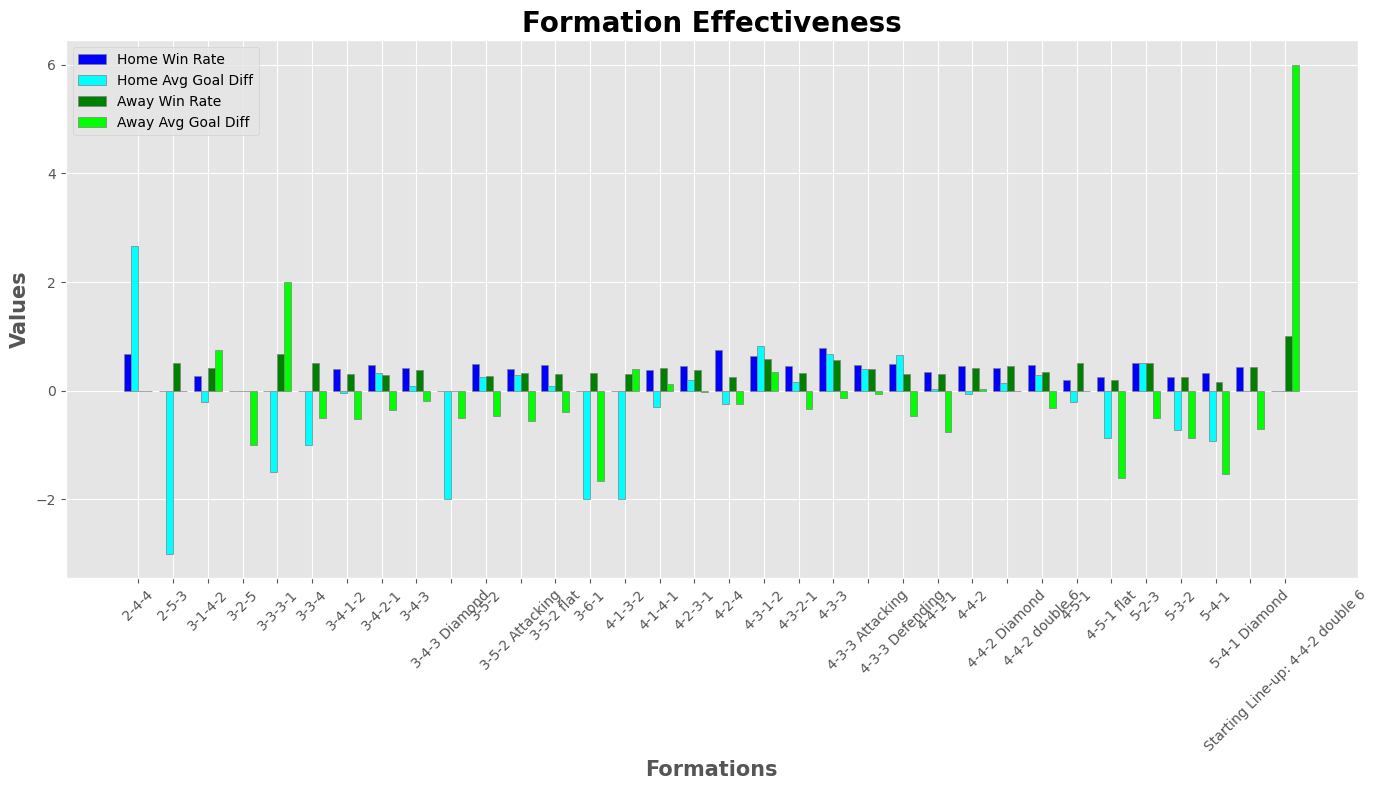

In [274]:
# Creating the bar plot and Figure
fig, ax1 = plt.subplots(figsize=(14, 8)) # Creates a figure and a set of subplots and sets the dimensions of the figure to be 14 inches wide and 8 inches tall.
# fig: Represents the entire figure.
# ax1: Represents the axes of the subplot, where the data will be plotted.

# Preparing the Data
formations = formation_effectiveness.index # Extracts the index of the formation_effectiveness DataFrame, which contains the formations.

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
r1 = range(len(formations))      # Positions for the first set of bars (home win rate).
r2 = [x + bar_width for x in r1] # Positions for the second set of bars (home average goal difference), shifted right by bar_width.
r3 = [x + bar_width for x in r2] # Positions for the third set of bars (away win rate), shifted further right.
r4 = [x + bar_width for x in r3] # Positions for the fourth set of bars (away average goal difference), shifted even further right.

# Create the bars for home win rate and goal difference
ax1.bar(r1, formation_effectiveness['home_win_rate'], color='blue', width=bar_width, edgecolor='grey', label='Home Win Rate')
ax1.bar(r2, formation_effectiveness['home_avg_goal_diff'], color='cyan', width=bar_width, edgecolor='grey', label='Home Avg Goal Diff')

# Create the bars for away win rate and goal difference
ax1.bar(r3, formation_effectiveness['away_win_rate'], color='green', width=bar_width, edgecolor='grey', label='Away Win Rate')
ax1.bar(r4, formation_effectiveness['away_avg_goal_diff'], color='lime', width=bar_width, edgecolor='grey', label='Away Avg Goal Diff')

# Add labels and title
ax1.set_xlabel('Formations', fontweight='bold', fontsize=15) # Sets the label for the x-axis.
ax1.set_ylabel('Values', fontweight='bold', fontsize=15)    # Sets the label for the y-axis.
ax1.set_title('Formation Effectiveness', fontweight='bold', fontsize=20) # Sets the title of the plot.

# Adjust x-axis tick positions and labels
ax1.set_xticks([r + bar_width*1.5 for r in range(len(formations))]) # Sets the positions of the x-axis ticks.
ax1.set_xticklabels(formations, rotation=45) # Sets the labels for the x-axis ticks with rotation for better readability.

# Add legend
ax1.legend() # Adds a legend to the plot based on the labels specified in the ax.bar() calls.

# Show the plot
plt.tight_layout() # Adjusts subplot parameters to give specified padding.
plt.show()         # Displays the plot.

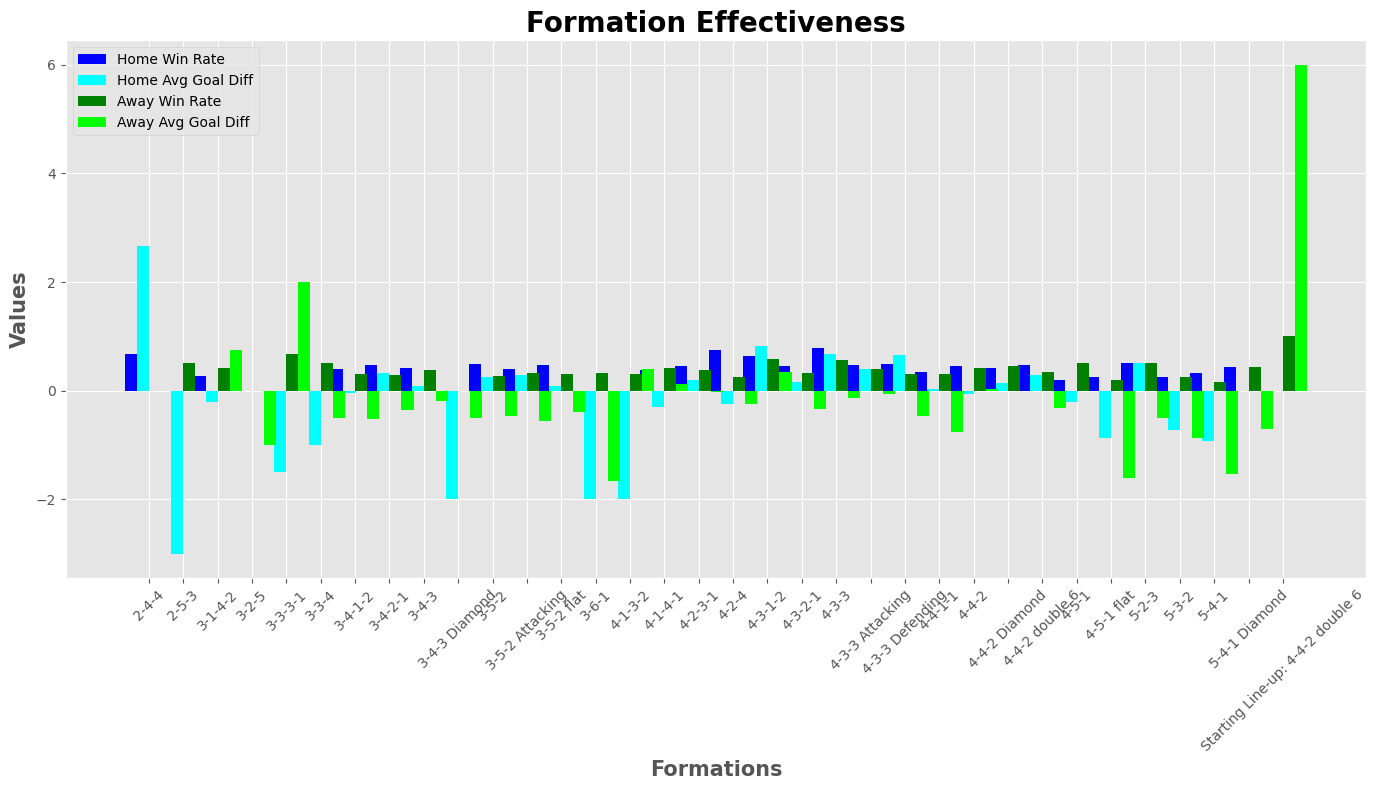

In [275]:
import matplotlib.pyplot as plt

# Creating the bar plot for win rates and goal differences
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35
index = range(len(formation_effectiveness))

# Plotting home win rate and average goal difference
ax.bar(index, formation_effectiveness['home_win_rate'], bar_width, label='Home Win Rate', color='blue')
ax.bar([i + bar_width for i in index], formation_effectiveness['home_avg_goal_diff'], bar_width, label='Home Avg Goal Diff', color='cyan')

# Plotting away win rate and average goal difference
ax.bar([i + bar_width * 2 for i in index], formation_effectiveness['away_win_rate'], bar_width, label='Away Win Rate', color='green')
ax.bar([i + bar_width * 3 for i in index], formation_effectiveness['away_avg_goal_diff'], bar_width, label='Away Avg Goal Diff', color='lime')

# Add labels and title
ax.set_xlabel('Formations', fontweight='bold', fontsize=15)
ax.set_ylabel('Values', fontweight='bold', fontsize=15)
ax.set_title('Formation Effectiveness', fontweight='bold', fontsize=20)
ax.set_xticks([i + bar_width * 1.5 for i in index])
ax.set_xticklabels(formations, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()
